# Section 1: Define tickers & time range

In [14]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize

### Defining the universe of tickers

In [15]:
# fill with yfinance
tickers = ["SPY","AMD","GLD","QQQ","GOOG"]

### Set the relevant dates

In [16]:
end_date = datetime.today()
start_date = end_date - timedelta(days = 20*365)

# Section 2: Download adjusted close prices

### Create an empty DataFrame to store adjusted close prices

In [17]:
adj_close_df = pd.DataFrame()

### Download the close prices for each ticker

In [18]:
for ticker in tickers:
    data = yf.download(ticker, start = start_date, end = end_date)
    adj_close_df[ticker] = data["Adj Close"]  

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### Display the dataframe

In [19]:
print (adj_close_df)

                   SPY         AMD         GLD         QQQ        GOOG
Date                                                                  
2004-01-27   78.218903   15.560000         NaN   32.240799         NaN
2004-01-28   77.325386   15.300000         NaN   31.694042         NaN
2004-01-29   77.400414   14.680000         NaN   31.813652         NaN
2004-01-30   77.400414   14.860000         NaN   31.668423         NaN
2004-02-02   77.734596   14.640000         NaN   31.582972         NaN
...                ...         ...         ...         ...         ...
2024-01-12  476.679993  146.559998  189.710007  409.559998  144.240005
2024-01-16  474.929993  158.740005  187.910004  409.519989  144.080002
2024-01-17  472.290009  160.169998  185.839996  407.209991  142.889999
2024-01-18  476.489990  162.669998  187.369995  412.989990  144.990005
2024-01-19  482.429993  174.229996  187.929993  421.179993  147.970001

[5030 rows x 5 columns]


# Section 3: Calculate lognormal results

### Calculate the daily log results for each ticker

In [20]:
log_returns = np.log(adj_close_df).pct_change()
print (log_returns)

                 SPY       AMD       GLD       QQQ      GOOG
Date                                                        
2004-01-27       NaN       NaN       NaN       NaN       NaN
2004-01-28 -0.002635 -0.006139       NaN -0.004925       NaN
2004-01-29  0.000223 -0.015165       NaN  0.001090       NaN
2004-01-30  0.000000  0.004536       NaN -0.001322       NaN
2004-02-02  0.000991 -0.005527       NaN -0.000782       NaN
...              ...       ...       ...       ...       ...
2024-01-12  0.000112 -0.001984  0.001862  0.000085  0.000797
2024-01-16 -0.000596  0.016007 -0.001817 -0.000016 -0.000223
2024-01-17 -0.000904  0.001770 -0.002116 -0.000940 -0.001669
2024-01-18  0.001438  0.003051  0.001569  0.002345  0.002940
2024-01-19  0.002009  0.013483  0.000570  0.003260  0.004088

[5030 rows x 5 columns]


### Drop any missing values

In [21]:
log_returns = log_returns.dropna()
print (log_returns)

                 SPY       AMD       GLD       QQQ      GOOG
Date                                                        
2004-11-19 -0.002536 -0.017412  0.002366 -0.004454  0.007728
2004-11-22  0.001082  0.002366  0.000997  0.002722 -0.017860
2004-11-23  0.000346  0.006674 -0.001172 -0.000438  0.010291
2004-11-24  0.000537  0.002736  0.001758  0.002477  0.029619
2004-11-26 -0.000172 -0.000453  0.001395 -0.000869  0.017779
...              ...       ...       ...       ...       ...
2024-01-12  0.000112 -0.001984  0.001862  0.000085  0.000797
2024-01-16 -0.000596  0.016007 -0.001817 -0.000016 -0.000223
2024-01-17 -0.000904  0.001770 -0.002116 -0.000940 -0.001669
2024-01-18  0.001438  0.003051  0.001569  0.002345  0.002940
2024-01-19  0.002009  0.013483  0.000570  0.003260  0.004088

[4823 rows x 5 columns]


# Section 4: Calculate covariance matrix

### Calculate the covariance matrix using annualized log results

In [22]:
cov_matrix = log_returns.cov()*252
print (cov_matrix)

           SPY       AMD       GLD       QQQ      GOOG
SPY   0.001613  0.006941  0.000081  0.001909  0.002669
AMD   0.006941  0.160880 -0.000063  0.009024  0.011513
GLD   0.000081 -0.000063  0.001455  0.000065  0.000056
QQQ   0.001909  0.009024  0.000065  0.002669  0.003852
GOOG  0.002669  0.011513  0.000056  0.003852  0.011925


# Section 5: Define Portfolio Performance Metrics

### Calculate the portfolio standard deviation

In [23]:
def standard_deviation (weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

### Calculate the expected return

In [24]:
# key assumption is that expected returns are based on historical returns; to improve, consider looking at momentum
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

finding expected returns through CAPM




### Calculate the Sharpe Ratio

In [25]:
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate)/standard_deviation(weights, cov_matrix)

# Section 6: Portfolio Optimization

### Set the risk free rate

In [26]:
from fredapi import Fred

fred = Fred(api_key = "cde66891b7b28b5d3f9629c16e2fc209")
ten_year_treasury_rate = fred.get_series_latest_release("GS10")/100

risk_free_rate = ten_year_treasury_rate.iloc[-1]
print (risk_free_rate)

0.04019999999999999


### Define the function to output maximum Sharpe Ratio

In [27]:
# through this method, we are effectively maximising Sharpe Ratio
def neg_sharpe_ratio (weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

### Set constraints and bounds

In [28]:
constraints = {"type": "eq", "fun": lambda weights: np.sum(weights)-1}
bounds = [(0,0.3) for _ in range (len(tickers))]

### Set the initial weights

In [29]:
initial_weights = np.array([1/len(tickers)]*len(tickers))
print (initial_weights)

[0.2 0.2 0.2 0.2 0.2]


### Optimise weights to maximise Sharpe Ratio

In [30]:
# SLSQP stands for Sequential Least Squares Quadratic Programming - it is used to solve nonlinear optimisation problems with constraints
optimized_results = minimize (neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method = 'SLSQP', constraints=constraints, bounds=bounds)

# Section 7: Analyze the Optimal Portfolio

### Display analytics of the optimal portfolio

In [31]:
optimal_weights = optimized_results.x

print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
SPY: 0.0000
AMD: 0.3000
GLD: 0.1000
QQQ: 0.3000
GOOG: 0.3000
Expected Annual Return: 0.0638
Expected Volatility: 0.1421
Sharpe Ratio: 0.1663


### Display the final portfolio in a plot

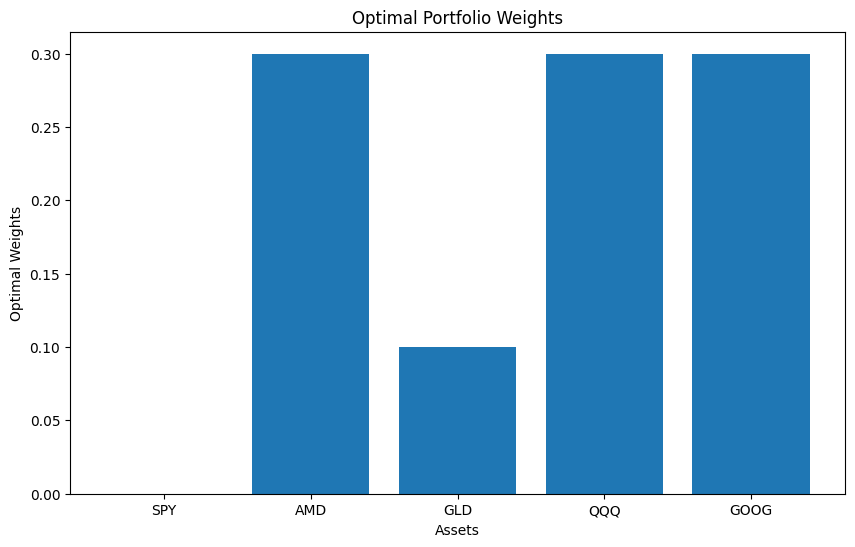

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()